### Popmodel EDA
###### Imports


In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_validate
import imblearn
from math import sqrt

###### Notebook Settings

In [94]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

sns.set_style("whitegrid")

plt.rcParams.update({'figure.figsize': (12.0, 12.0)})
plt.rcParams.update({'font.size': 14})

###### Feature Engineering

In [95]:
#Read CSVs
data = pd.read_csv("SpotifyData.csv")
add_infos = pd.read_csv("additional_infos.csv")

In [96]:
#Adjust inconsistent genre naming
data.loc[data["genre"] == 'Children’s Music', "genre"] = "Children Music"
data.loc[data["genre"] == "Children's Music", "genre"] = "Children Music"

In [97]:
#Join duplicate tracks assigned to different genres together in one common row
genre_df = data.groupby(['track_id'])['genre'].apply(', '.join).reset_index()

In [98]:
#Drop duplicates by track ID and remove ID column
data.drop_duplicates("track_id", inplace=True)
data.sort_values("track_id", inplace=True)
data.reset_index(inplace=True, drop=True)

In [99]:
#Assign Features
X = data

In [100]:
#Replace genre column in original dataset
X["genre"] = genre_df["genre"]

In [101]:
#Genre encoding seperate since there can be multiple values in one row
X = pd.concat([X, X['genre'].str.get_dummies(sep=', ')], axis=1)
X = pd.concat([X, pd.get_dummies(X[["key","mode","time_signature"]])], axis=1)
X.drop(["key","mode","time_signature","genre"], axis=1, inplace=True)

In [102]:
#Add explicit feature from external dataset
add_infos.sort_values("id", inplace=True)
assert pd.Series(add_infos["id"].values == X["track_id"].values).value_counts().values[0] == len(add_infos)
X["explicit"] = add_infos["explicit"]
X["track_number"] = add_infos["track_number"]

In [103]:
#Get release Date from String and create new feature
temp = []
for i in range(len(add_infos)):
    temp += [int(add_infos["album"][i][add_infos["album"][i].find("release_date") + 16: add_infos["album"][i].find("release_date") + 20])]
X["release_date"] = temp
X.loc[X["release_date"] == 0000, "release_date"] = X["release_date"].values.mean().round()

In [104]:
#Get total track number from String and create new feature
temp = []
for i in range(len(add_infos)):
    if add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 16] == ",":
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 16])]
    elif add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 17] == ",":
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 17])]
    else:
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 18])]
X["total_tracks"] = temp

In [105]:
#Get artist id from String and create new feature
temp = []
for i in range(len(add_infos)):
    temp += [add_infos["album"][i][add_infos["album"][i].find("id") + 6: add_infos["album"][i].find("id") + 28]]
X["artist_id"] = temp

In [106]:
#encoding track id and artist
lenc = OrdinalEncoder()
X["track_id"] = lenc.fit_transform(X["track_id"].values.reshape(-1,1))
X["artist_id"] = lenc.fit_transform(X["artist_id"].values.reshape(-1,1))
X["track_name"] = lenc.fit_transform(X["track_name"].values.reshape(-1,1))
X["artist_name"] = lenc.fit_transform(X["artist_name"].values.reshape(-1,1))

In [ ]:
#Drop Songs with zero popularity
X.drop(X[X["popularity"] == 0].index, inplace=True)
len(X)


In [ ]:
#Drop voice only audio tracks
X.drop(X[X["speechiness"] > 0.70].index, inplace=True)
len(X)

In [107]:
#Assign Prediction Target
y = X["popularity"]
X.drop(["popularity"], axis=1, inplace=True)

In [ ]:
#Class binning of y
est = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
y = pd.DataFrame(est.fit_transform(y.values.reshape(-1, 1)))



In [ ]:
# Drop the categorical columns
X.drop(["track_id", "artist_name", "track_name", "artist_id"], axis=1, inplace=True)

In [ ]:
#Scaling all features (Brings less accuracy)
minni = MinMaxScaler()
pd.DataFrame(minni.fit_transform(X))

In [ ]:
#Scaling all features (Brings less accuracy)
minni = MinMaxScaler()
pd.DataFrame(minni.fit_transform(X))

In [ ]:
#SweeViz
my_report = sv.analyze(data)
my_report.show_html()

In [ ]:
#SweeViz
my_report = sv.analyze(X)
my_report.show_html()


In [108]:
pop = y.value_counts().sort_index()
pd.DataFrame(pop).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
popularity,6170,1285,903,811,805,913,787,773,921,986,1253,1432,1560,1664,1566,1699,1576,1658,1617,1866,1978,2244,2450,2635,2812,3087,3166,3378,3747,3795,3717,3766,3859,3895,3721,3856,3919,3796,3980,3819,3920,4051,4015,3954,3929,3734,3715,3693,3612,3583,3390,3199,3023,2847,2658,2421,2265,2108,1911,1769,1705,1504,1434,1295,1170,1054,948,799,730,638,575,509,435,411,327,240,222,204,170,134,117,81,74,57,58,46,39,32,21,14,14,16,10,6,3,7,3,6,1,2,1


In [ ]:

#sns.distplot(pop, bins=100)
plot_ = sns.barplot(pop.index[-25:],pop[-25:])
# for ind, label in enumerate(plot_.get_xticklabels()):
#     if ind % 11 == 0:  # every 10th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)

###### Models

In [ ]:
#Validation Set
X_valid = X.sample(frac=0.1,random_state=1, replace=False)
X.drop(X_valid.index, inplace=True)

y_valid = y.iloc[X_valid.index]
y.drop(y_valid.index, inplace=True)

X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X_valid.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

In [ ]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, shuffle=True)

In [ ]:
#Over and undersampling (Decreases Scores)
smote = imblearn.over_sampling.SMOTE(sampling_strategy='minority', random_state=3, n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train,y_train)
len(X)

In [ ]:
#PopModel
rfc = RandomForestRegressor(min_samples_split=11, verbose=1, n_jobs=-1, n_estimators=100)

In [ ]:
#Fit
rfc.fit(X_train, y_train)

In [ ]:
#Predict Traindata
pred_train = rfc.predict(X_train)
sns.regplot(y_train, pred_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


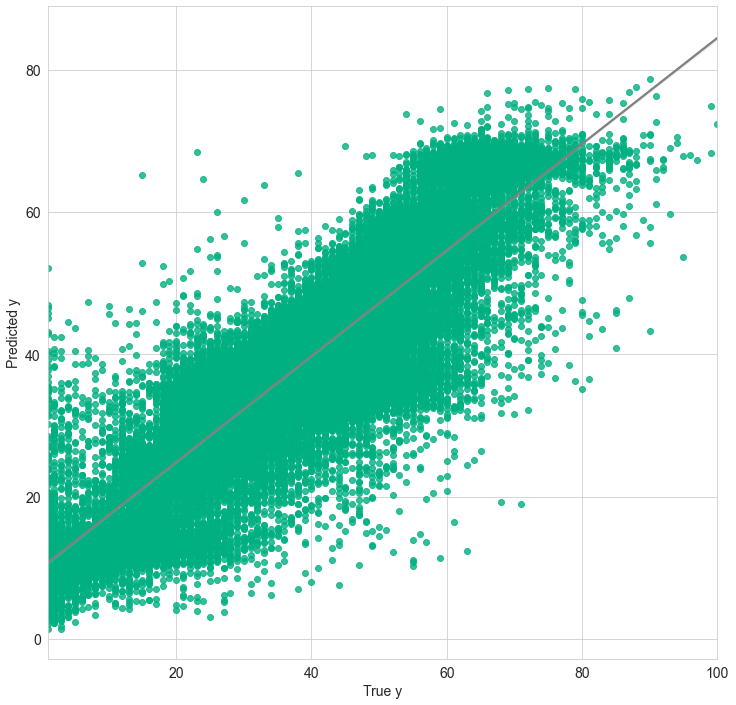

In [116]:
#Predict Testdata
pred_test = rfc.predict(X_test)
seab = sns.regplot(y_test, pred_test, scatter_kws={"color": "#00b081"}, line_kws={"color": "gray"})
seab.set(xlabel='True y', ylabel='Predicted y')
plt.savefig("regplot.png")

In [117]:
data[data["track_id"] == "4oKeAkeT2V1PBWfyywGAnL"]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
109411,Dance,David Guetta,Goodbye,4oKeAkeT2V1PBWfyywGAnL,0,0.0776,0.643,195419,0.904,0.0,C,0.189,-3.694,Major,0.0739,103.028,4/4,0.481


In [ ]:
#Metrics
RMSE = sqrt(mean_squared_error(y_test, pred_test.round().astype(int).tolist()))
print("RMSE: " + str(RMSE))

MAE = mean_absolute_error(y_test, pred_test.round().astype(int).tolist())
print("MAE: " + str(MAE))

r2 = r2_score(y_test, pred_test.round().astype(int).tolist())
print("R²: " + str(r2))

In [ ]:
#Cross Validation
scores = cross_validate(rfc, X, y, cv=5, scoring=('r2', 'neg_mean_squared_error', "neg_median_absolute_error", 'neg_mean_absolute_error'), return_train_score=True)

print("test_r2: %0.2f (+/- %0.2f)" % (scores["test_r2"].mean(), scores["test_r2"].std() * 2))
print("test_neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores["test_neg_mean_squared_error"].mean(), scores["test_neg_mean_squared_error"].std() * 2))
print("test_neg_median_absolute_error: %0.2f (+/- %0.2f)" % (scores["test_neg_median_absolute_error"].mean(), scores["test_neg_median_absolute_error"].std() * 2))
print("test_neg_mean_absolute_error: %0.2f (+/- %0.2f)" % (scores["test_neg_mean_absolute_error"].mean(), scores["test_neg_mean_absolute_error"].std() * 2))

In [ ]:
pred = rfc.predict(X_valid)

In [ ]:
d= {"True":y_test, "Predict":pred.round().astype(int).tolist()}
erg = pd.DataFrame(d)
erg

In [ ]:
erg.to_csv("erg.csv")

In [ ]:
rfc.score(X_valid, y_valid)

In [ ]:
mean_squared_error(y_valid,pred.round().astype(int).tolist())

In [ ]:
mean_absolute_error(y_valid, pred.round().astype(int).tolist())

In [ ]:
r2_score(y_valid, pred.round().astype(int).tolist())

In [ ]:
sns.regplot(y_valid, pred.round().astype(int).tolist())

In [ ]:
lenc.inverse_transform(X_valid["track_id"].iloc[1082:1083])

In [ ]:
###GridSearchCV


params = { "n_estimators": [100]
           }

gsearch = GridSearchCV(estimator=m,
                       param_grid=params,
                       cv=5,
                       verbose=1,
                       n_jobs=-1
                       )


In [ ]:

gsearch.fit(X_train, y_train)

print("\nScore: " + str(round(gsearch.score(X_train, y_train),4)))

print("\nBest Parameters: "+ str(gsearch.best_params_))

In [ ]:
X.reset_index(inplace=True)

In [ ]:

X.drop(["index", "level_0"], axis=1, inplace=True)
X



In [ ]:
from sklearn.linear_model import LinearRegression
# RMSE: 9.7
# MAE: 7.35
# R²: 0.633
from sklearn.linear_model import Lasso #RMSE: 14.61
from sklearn.linear_model import LassoLars #RMSE: 16.07
from sklearn.linear_model import Ridge #same as linear regression
from sklearn.linear_model import RidgeCV #same as linear regression
from sklearn.linear_model import BayesianRidge #same as linear regression
from sklearn.linear_model import TheilSenRegressor #same as linear regression
from xgboost import XGBRegressor
# RMSE: 8.300204795862877
# MAE: 6.284962437051102
# R²: 0.7331425830142111

In [ ]:
model_x = XGBRegressor(seed=27, colsample_bytree=0.9, subsample=0.8,
                       gamma=0.2, min_child_weight=1, max_depth=5, n_estimators=1000, learning_rate =0.3,
                       sampling_method="gradient_based", random_state=3, n_jobs=-1, tree_method='gpu_hist',
                       predictor= 'gpu_predictor', verbosity=2)

model_x = LassoLars()


model_x.fit(X_train, y_train)


pred = model_x.predict(X_test)

RMSE = sqrt(mean_squared_error(y_test, pred.round().astype(int).tolist()))
print("RMSE: " + str(RMSE))

MAE = mean_absolute_error(y_test, pred.round().astype(int).tolist())
print("MAE: " + str(MAE))

r2 = r2_score(y_test, pred.round().astype(int).tolist())
print("R²: " + str(r2))